In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import polars as pl
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import arviz as az
import preliz as pz 
import pymc as pm

import os

COLOR_DICT = {
    "BLUE": "#2a5674",
    "RED": "#b13f64",
    "GOLD": "#e6b54a",
    "TEAL": "#4a9b8f",
    "CORAL": "#f47c65",
    "PURPLE": "#6a4a99",
    "ORANGE": "#f28c28",
    "GREEN": "#4a9b4a",
    "PINK": "#d47ca6"
}

colors = [COLOR_DICT[KEY] for KEY in COLOR_DICT.keys()]

In [2]:
DATA_PATH = r"C:\baseball_python\data\savant\season_data"

df_list = []
for season in [2023,2024,2025]:
    df_list.append(
        pl.scan_ipc(os.path.join(DATA_PATH,f"{season}.feather"))
        .filter(pl.col("game_type")=="R")
        .select([
            "age_bat",
            "batter",
            "pitcher",
            "game_year",
            "game_date",
            "game_pk",
            "bat_speed",
            "swing_length",
            "attack_angle",
            "attack_direction",
            "swing_path_tilt",
            "launch_speed",
            "launch_angle",
            "balls",
            "strikes",
            "pitch_type",
            "release_speed",
            "stand",
            "p_throws",
            "intercept_ball_minus_batter_pos_x_inches",
            "intercept_ball_minus_batter_pos_y_inches",
        ])
        .rename({"intercept_ball_minus_batter_pos_x_inches":"int_x","intercept_ball_minus_batter_pos_y_inches":"int_y"})
        .collect()
    )

df = pl.concat(df_list)

In [3]:
batter_df = (
    df
    .with_columns(
        pl.col("bat_speed").quantile(0.1,"nearest").over(["batter", "game_year", "stand"]).alias("10pctile_bat_speed"),
    )
    .filter(
        (pl.col("bat_speed") > pl.col("10pctile_bat_speed")) |
        ((pl.col("bat_speed") >= 60) & (pl.col("launch_speed") >= 90))
    )
    .with_columns(
        pl.col("release_speed").mean().over(["pitcher","pitch_type"]).alias("release_speed_mean_pitcher_pitch"),
    )
    .with_columns(
        pl.when((pl.col("release_speed_mean_pitcher_pitch")>90)&(pl.col("pitch_type")=="FC"))
            .then(pl.lit("HC"))
            .otherwise(pl.col("pitch_type"))
            .alias("pitch_sub_type"),
    )
    .filter(pl.col("strikes")<2)
    .filter(pl.col("pitch_sub_type").is_in(["FF","SI","HC"]))
    .select([
        "batter",
        "game_year",
        "game_pk",
        "bat_speed",
        "swing_length",
        "attack_direction",
        "attack_angle",
        "swing_path_tilt",
        "int_x",
        "int_y",
        "age_bat",
    ])
    .group_by([
        "batter",
        "game_year",
        "game_pk",
    ])
    .agg(
        pl.count().alias("n"),
        pl.col("age_bat").min().alias("age_bat"),
        pl.col("bat_speed").mean().alias("bat_speed_mean"),
        pl.col("bat_speed").quantile(0.9).alias("bat_speed_90"),
        pl.col("swing_length").mean().alias("swing_length_mean"),
        pl.col("attack_direction").mean().alias("attack_direction_mean"),
        pl.col("attack_angle").mean().alias("attack_angle_mean"),
        pl.col("swing_path_tilt").mean().alias("swing_path_tilt_mean"),
        pl.col("int_x").mean().alias("int_x_mean"),
        pl.col("int_y").mean().alias("int_y_mean"),
    )
    .filter(pl.col("n")>=2) # only keep games with at least two swings
    .with_columns(
        pl.count().over(["batter","game_year"]).alias("n_season"),
    )
    .filter(pl.col("n_season")>=5) # only keep seasons with at least 5 games
    .with_columns(
        pl.col("game_year").n_unique().over(["batter"]).alias("n_seasons"),
    )
    .filter(pl.col("n_seasons")>=2) # only keep batters with at least two seasons
    .drop_nulls()
    .to_pandas()
)

batter_season = (
    df
    .with_columns(
        pl.col("bat_speed").quantile(0.1,"nearest").over(["batter", "game_year", "stand"]).alias("10pctile_bat_speed"),
    )
    .filter(
        (pl.col("bat_speed") > pl.col("10pctile_bat_speed")) |
        ((pl.col("bat_speed") >= 60) & (pl.col("launch_speed") >= 90))
    )
    .with_columns(
        pl.col("release_speed").mean().over(["pitcher","pitch_type"]).alias("release_speed_mean_pitcher_pitch"),
    )
    .with_columns(
        pl.when((pl.col("release_speed_mean_pitcher_pitch")>90)&(pl.col("pitch_type")=="FC"))
            .then(pl.lit("HC"))
            .otherwise(pl.col("pitch_type"))
            .alias("pitch_sub_type"),
    )
    .filter(pl.col("strikes")<2)
    .filter(pl.col("pitch_sub_type").is_in(["FF","SI","HC"]))
    .select([
        "batter",
        "game_year",
        "game_pk",
        "bat_speed",
        "swing_length",
        "attack_direction",
        "attack_angle",
        "swing_path_tilt",
        "int_x",
        "int_y",
        "age_bat",
    ])
    .group_by([
        "batter",
        "game_year",
    ])
    .agg(
        pl.count().alias("n"),
        pl.col("age_bat").min().alias("age_bat"),
        pl.col("bat_speed").mean().alias("bat_speed_mean"),
        pl.col("bat_speed").quantile(0.9).alias("bat_speed_90"),
        pl.col("swing_length").mean().alias("swing_length_mean"),
        pl.col("attack_direction").mean().alias("attack_direction_mean"),
        pl.col("attack_angle").mean().alias("attack_angle_mean"),
        pl.col("swing_path_tilt").mean().alias("swing_path_tilt_mean"),
        pl.col("int_x").mean().alias("int_x_mean"),
        pl.col("int_y").mean().alias("int_y_mean"),
    )
    .filter(pl.col("n")>100)
    .with_columns(
        pl.col("game_year").n_unique().over(["batter"]).alias("n_seasons"),
    )
    .filter(pl.col("n_seasons")>=2)
    .drop_nulls()
    .to_pandas()
)

batter_df["jittered_age"] = batter_df["age_bat"] + np.random.normal(0,0.5,len(batter_df))

batter_season["jittered_age"] = batter_season["age_bat"] + np.random.normal(0,0.5,len(batter_season))

In [4]:
len(batter_df["batter"].unique())

529

In [5]:
batter_df.head()

,batter,game_year,game_pk,n,age_bat,bat_speed_mean,bat_speed_90,swing_length_mean,attack_direction_mean,attack_angle_mean,swing_path_tilt_mean,int_x_mean,int_y_mean,n_season,n_seasons,jittered_age
0,606992,2025,778239,2,33.0,75.750000,78.3,7.25,8.669416,12.001623,35.455592,41.382331,26.651997,9,3,33.026622
1,666969,2025,778385,2,32.0,74.250000,75.0,7.50,6.757662,6.213686,22.690425,41.282984,26.994723,100,3,31.633595
2,691718,2024,746848,3,22.0,72.633333,74.8,6.90,9.516509,8.239530,36.570553,35.713173,27.796023,80,3,22.361645
3,691594,2025,778519,2,23.0,67.650000,71.6,6.80,12.964584,-5.676147,22.365985,36.688339,18.753437,53,2,23.386410
4,643396,2025,777002,2,30.0,71.250000,71.5,6.70,6.911280,1.447289,32.956569,37.464362,25.664676,70,3,30.040774


In [6]:
batter_df.shape

(67834, 16)

In [7]:
var_dict = {
    "int_y_mean":{
        "title":"Mean Intercept Point",
        "final_label":" inches vs batter",
        },
    "bat_speed_mean":{
        "title":"Mean Bat Speed",
        "final_label":" MPH",
        },
    "attack_angle_mean":{
        "title":"Mean Attack Angle",
        "final_label":"""° 'uppercut'""",
        },
    "attack_direction_mean":{
        "title":"Mean Attack Direction",
        "final_label":"° oppo",
        },
}

In [8]:
## HSGP code below is pulled from Justin Choi here: https://github.com/justinochoi/bayesian_aging_curves/blob/main/hsgp_model.py

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: []


Output()

Sampling: []


Output()

Sampling: []


Output()

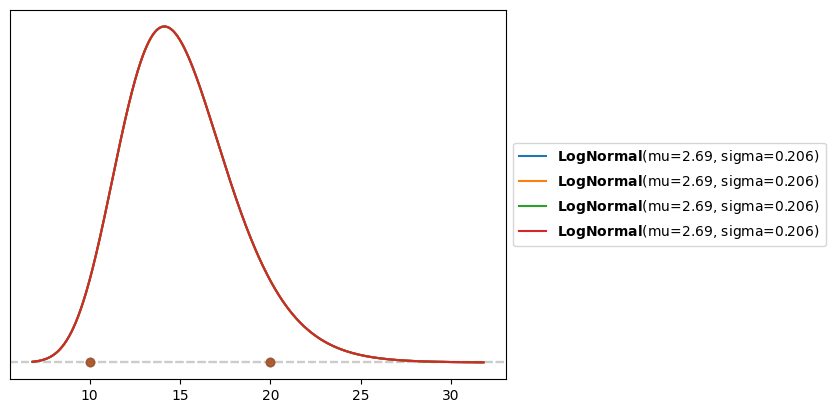

In [9]:
min_age = 19
max_age = batter_df["age_bat"].max()+1

new_data = pd.DataFrame({
    "batter":111111,
    "age_bat": np.linspace(min_age, max_age, int(max_age-min_age)+1),
})

for i, age_vari in enumerate(list(var_dict.keys())):
    BATTER_ID, BATTER = pd.factorize(batter_df["batter"])

    coords = {
        "batter": BATTER,
    }

    # creating a prior for the length scale 
    # intuitively, aging curves are not very "wiggly"
    # so we expected the ell term to be large 
    lower, upper = 10, 20 
    ell_dist, ax = pz.maxent(
        pz.LogNormal(),
        lower=lower,
        upper=upper,
        mass=0.9,
    )

    # recommended hyperparams based on x range and length scale prior 
    pm.gp.hsgp_approx.approx_hsgp_hyperparams(
        x_range=[20, 40], lengthscale_range=[10, 20], cov_func="expquad"
    )

    with pm.Model(coords=coords) as aging_model:

        ## DATA
        age_var = pm.Data("age_var", batter_df[age_vari].to_numpy().astype(np.float32),)
        age_bat = pm.Data("age_bat", batter_df["age_bat"].to_numpy().astype(np.float32),)
        batter_id = pm.Data("batter_id", BATTER_ID, dims="obs_id")

        ## BATTER RANDOM EFFECTS
        hyper_mean_mu_batter = pm.Normal("hyper_mean_mu_batter", 0, 1)
        hyper_mean_sigma_batter = pm.HalfNormal("hyper_mean_sigma_batter", 5)
        v_mean_batter = pm.Normal("v_mean_batter", 0, 1, dims=("batter"))
        mean_batter = pm.Deterministic("mean_batter",hyper_mean_mu_batter + hyper_mean_sigma_batter * v_mean_batter)

        ## GP from Justin
        ell = ell_dist.to_pymc("ell") 
        eta = pm.HalfNormal("eta", sigma=2.5)  

        cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)  
        gp = pm.gp.HSGP(m=[11], c=7, cov_func=cov) 

        f = gp.prior("f", X=age_bat[:, None])
        sigma = pm.HalfNormal("sigma", sigma=1) 

        ## Pull it all together
        mean_intercept = pm.Normal("mean_intercept",batter_df[age_vari].mean(),10)

        mean_final = pm.Deterministic(
            "mean_final",
            f + mean_batter[batter_id] + mean_intercept
        )

        y = pm.Normal("y", mu=mean_final, sigma=sigma, observed=age_var) 

    with aging_model:
        aging_idata = pm.sample(
            draws=500,
            tune=500,
            chains=4, cores=4,
            nuts_sampler="numpyro",
            random_seed=123,
            idata_kwargs={"log_likelihood": True}
        )

    median_batter = int(batter_season.sort_values(by=age_vari).iloc[int(len(batter_season)/2)]["batter"])
    new_data["batter"] = int(median_batter)

    with aging_model:

        pm.set_data({
            "batter_id": [np.where(BATTER==median_batter)[0].item() for name in new_data["batter"].to_numpy().squeeze()],
            "age_bat": new_data["age_bat"].values,
        })

        aging_post_plot = pm.sample_posterior_predictive(aging_idata,var_names=["mean_final"],predictions=True,extend_inferencedata=False)

    pps = aging_post_plot.predictions["mean_final"].to_numpy().reshape(2000,int(max_age-min_age)+1)
    qts = np.quantile(pps, q=(0.025, 0.5, 0.975), axis=0)

    new_data[f"{age_vari}_lower_pred"] = qts[0]
    new_data[f"{age_vari}_mean_pred"] = qts[1]
    new_data[f"{age_vari}_upper_pred"] = qts[2]

    median_batter = 663656
    new_data["batter"] = int(median_batter)

    with aging_model:

        pm.set_data({
            "batter_id": [np.where(BATTER==median_batter)[0].item() for name in new_data["batter"].to_numpy().squeeze()],
            "age_bat": new_data["age_bat"].values,
        })

        aging_post_plot = pm.sample_posterior_predictive(aging_idata,var_names=["mean_final"],predictions=True,extend_inferencedata=False)

    pps = aging_post_plot.predictions["mean_final"].to_numpy().reshape(2000,int(max_age-min_age)+1)
    qts = np.quantile(pps, q=(0.025, 0.5, 0.975), axis=0)

    new_data[f"{age_vari}_lower_pred_tucker"] = qts[0]
    new_data[f"{age_vari}_mean_pred_tucker"] = qts[1]
    new_data[f"{age_vari}_upper_pred_tucker"] = qts[2]

    median_batter = 656941
    new_data["batter"] = int(median_batter)

    with aging_model:

        pm.set_data({
            "batter_id": [np.where(BATTER==median_batter)[0].item() for name in new_data["batter"].to_numpy().squeeze()],
            "age_bat": new_data["age_bat"].values,
        })

        aging_post_plot = pm.sample_posterior_predictive(aging_idata,var_names=["mean_final"],predictions=True,extend_inferencedata=False)

    pps = aging_post_plot.predictions["mean_final"].to_numpy().reshape(2000,int(max_age-min_age)+1)
    qts = np.quantile(pps, q=(0.025, 0.5, 0.975), axis=0)

    new_data[f"{age_vari}_lower_pred_schwarber"] = qts[0]
    new_data[f"{age_vari}_mean_pred_schwarber"] = qts[1]
    new_data[f"{age_vari}_upper_pred_schwarber"] = qts[2]

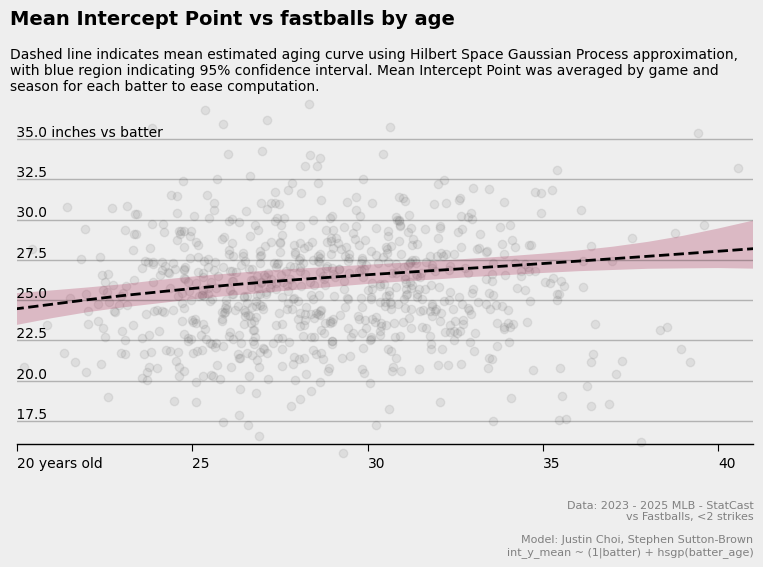

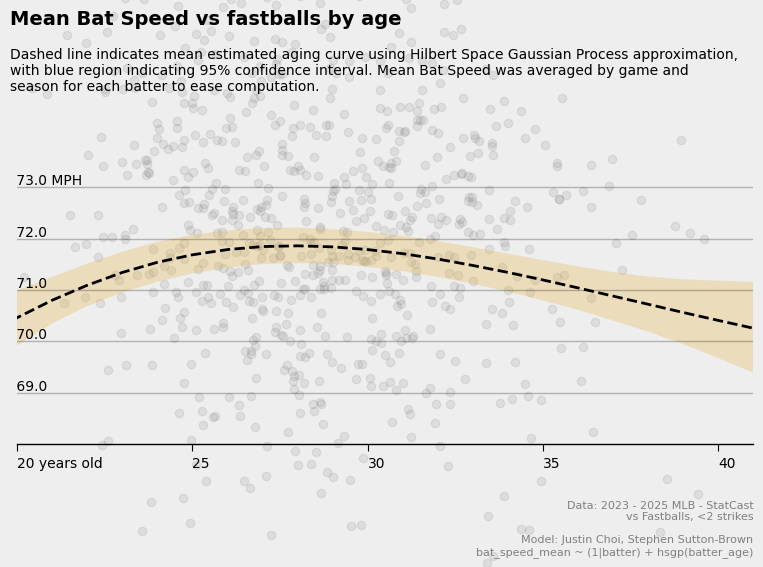

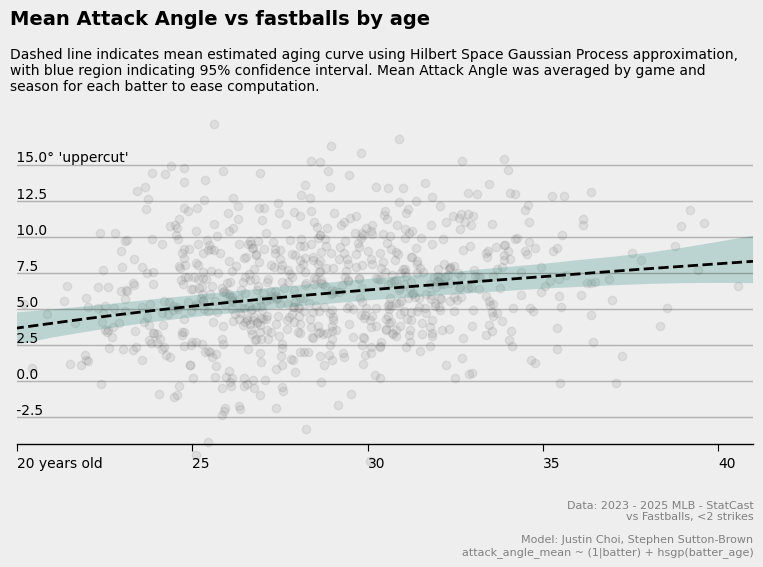

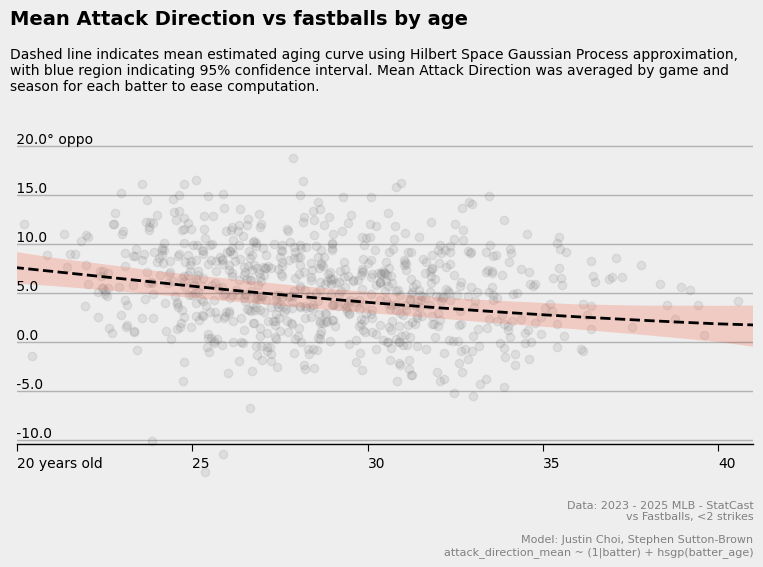

In [18]:
for i, age_vari in enumerate(var_dict.keys()):
    ## Plot aging curve HSGP

    fig, ax = plt.subplots(facecolor="#eeeeee",figsize=(9.5,4))
    ax.set_facecolor("#eeeeee")

    if "bat_speed" in age_vari:
        qts = [
            new_data[f"{age_vari}_lower_pred"].values,
            new_data[f"{age_vari}_mean_pred"].values,
            new_data[f"{age_vari}_upper_pred"].values,
        ]
    else:
        qts = [
            new_data[f"{age_vari}_lower_pred"].values,
            new_data[f"{age_vari}_mean_pred"].values,
            new_data[f"{age_vari}_upper_pred"].values,
        ]

    ax.scatter(
        batter_season.loc[(batter_season["jittered_age"].between(min_age+1,max_age-1)),"jittered_age"],
        batter_season.loc[(batter_season["jittered_age"].between(min_age+1,max_age-1)),age_vari],
        color="gray",
        alpha=0.15,
        zorder=0,
        clip_on=False,
    )

    ax.fill_between(
        new_data["age_bat"],
        qts[0],
        qts[2],
        color=colors[i+1],
        alpha=0.3,
        edgecolor=None,
    )

    ax.plot(
        new_data["age_bat"],
        qts[1],
        color="black",
        ls="--",
        lw=2,
    )

    ax.spines[["top","right","left"]].set_visible(False)
    ax.spines[["bottom"]].set_visible(True)
    ax.spines[["bottom"]].set_linewidth(1)
    ax.spines[["bottom"]].set_color("black")

    ax.grid(True, axis="y")
    ax.grid(False, axis="x")
    ax.tick_params(axis="x",direction="out",length=5)
    ax.tick_params(axis="y",direction="in",length=0,grid_color="black",grid_alpha=0.25,grid_linewidth=1)

    ax.set(xlabel="", ylabel="")

    x_ticks = np.linspace(min_age+1,40,5)
    ax.set_xticks(x_ticks)
    x_tick_labels = [str(int(tick)) for tick in x_ticks]
    x_tick_labels[0]+=" years old"
    ax.set_xticklabels(x_tick_labels,fontsize=10,ha="left")
    ax.set_xlim(min_age+1,max_age-1)

    if age_vari=="bat_speed_mean":
        ax.set_ylim(68,74)
    elif age_vari=="bat_speed_90":
        ax.set_ylim(70,80)
    else:
        ax.set_ylim(batter_df[age_vari].quantile(.05),batter_df[age_vari].quantile(0.95))
    y_ticks = ax.get_yticks()[1:-1]
    ax.set_yticks(y_ticks)
    y_tick_labels = [f" {tick:.1f}" for tick in y_ticks]
    y_tick_labels[-1]+=var_dict[age_vari]["final_label"]
    ax.set_yticklabels(y_tick_labels,fontsize=10,ha="left",va="bottom")

    ax.set_yticklabels(ax.get_yticklabels(),fontsize=10,ha="left",va="bottom")

    new_line = fig.text(
        s=f"""{var_dict[age_vari]['title']} vs fastballs by age""",
        x=0.1175,
        y=1.15,
        ha="left",
        va="bottom",
        fontsize=14,
        fontweight="bold",
    )

    new_line = ax.annotate(
        xy=(0,-1),
        xycoords=new_line,
        ha="left",
        va="top",
        text=f"""Dashed line indicates mean estimated aging curve using Hilbert Space Gaussian Process approximation, 
with blue region indicating 95% confidence interval. {var_dict[age_vari]['title']} was averaged by game and 
season for each batter to ease computation."""
    )

    new_line_bottom = fig.text(
        s = f"""
Data: 2023 - 2025 MLB - StatCast
vs Fastballs, <2 strikes

Model: Justin Choi, Stephen Sutton-Brown
{age_vari} ~ (1|batter) + hsgp(batter_age)""",
        x=0.9,
        ha="right",
        y=0,
        va="top",
        fontsize=8,
        color="gray",    
    )

    plt.show()